# Modeling

Our baseline model is a random forest classifier.Following steps will be performed to optimize the model:

1. Feature selection using Recursive Feature Selection with cross-validation on entire dataset
2. Avoid redundancy
3. Create balanced dataset
4. Tune hyperparameters
5. Validate model

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sqlalchemy import create_engine
import psycopg2

In [2]:
#Read file
full_path='../data/processed/mean_impute_all_features.csv'
dataframe = read_csv(full_path)
dataframe.reset_index(drop=True, inplace=True)
X, y= dataframe.drop('gestational dm', axis=1), dataframe['gestational dm'] 
seed=10

#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)
X.shape, y.shape

((132, 9), (132,))

In [81]:
#Setting up connection to postgres db
# rds_connection_string = "<postgres>:<password>@localhost:5432/insight_project"
# # engine = create_engine(f'postgresql://{rds_connection_string}')
# engine = create_engine(f'postgres+psycopg2://{rds_connection_string}')
# engine.table_names()

In [85]:
#Functions:
# Check if the labels are well shuffled in train and test set, to avoid imbalanced data
def bin_count(y_train, y_test):
    """
    Function to check class distribution in train and test set
    Arguments:y_train and y_test
    Returns: Prints bincount per class for each set
    """
    a,b=np.bincount(y_train)
    print(f"Percentage of data distribution in the train set:")
    print(round(a/(a+b)*100,2))
    print(round(b/(a+b)*100,2))
    print("-------------------")
    x,y=np.bincount(y_test)
    print(f"Percentage of data distribution in the test set:")
    print(round(x/(x+y)*100,2))
    print(round(y/(x+y)*100,2))

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def conf_matrix(y_test, y_pred):
    """Function to generate confusion matrix and generate report
       Arg: true labels and predicted labels array
    """
    cm = confusion_matrix(y_test, y_pred)
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm,fmt=".0f", annot=True, linewidths=0.2, linecolor="purple", ax=ax)
    plt.xlabel("Predicted")
    plt.ylabel("Grand Truth")
    plt.show()
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = 2*(Recall * Precision) / (Recall + Precision)
    return pd.DataFrame([[Precision, Recall, F1_Score]],columns=["Precision", "Recall", "F1 Score"], index=["Results"])

#Train random forst model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
def randomForest(X_train, X_test, y_train, y_test):
    """
    Function to train model
    Argumens: train and test data
    Returns: Score, classification report, model
    """
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred)
    return score, report, rf, y_pred

## Feature Selection

Optimal number of features : 8


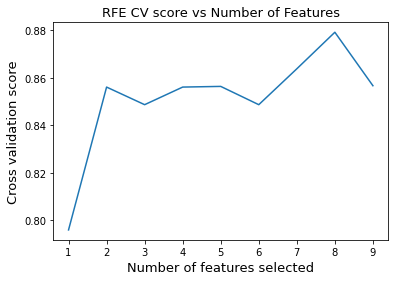

<Figure size 432x288 with 0 Axes>

In [89]:
#RFECV using RF estimator
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
selector=rfecv.fit(X, y)
selector
print("Optimal number of features : %d" % selector.n_features_)
plt.figure()
plt.title('RFE CV score vs Number of Features', fontsize=13)
plt.xlabel("Number of features selected", fontsize=13)
plt.ylabel("Cross validation score", fontsize=13)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show();
plt.savefig("Feature_selection");

8 features required for optimum accuracy

In [20]:
#Check the names of features to be retained 
feature_names=X.columns
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
print(new_features)

['age (years)', 'mean diastolic bp (mmhg)', 'mean systolic bp (mmhg)', 'central armellini fat (mm)', 'current gestational age', 'pregnancies (number)', 'first fasting glucose (mg/dl)', 'bmi pregestational (kg/m)']


Ethnicity is dropped

In [92]:
#First drop only the feature suggested
features=X.drop(['ethnicity'], axis=1)
features.head()

#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.20, random_state=seed, stratify=y)
bin_count(y_train, y_test)

Percentage of data distribution in the train set:
86.67
13.33
-------------------
Percentage of data distribution in the test set:
85.19
14.81


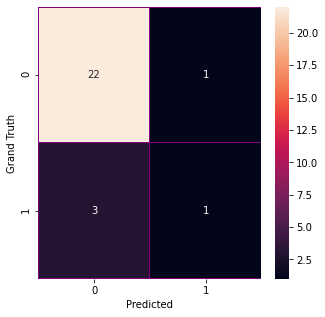

,Precision,Recall,F1 Score
Results,0.5,0.25,0.333333


In [93]:
#Train default model
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [94]:
#Redo by dropping correlated features:
data=X.drop(['ethnicity', 'central armellini fat (mm)', 'mean diastolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 6), (105,))

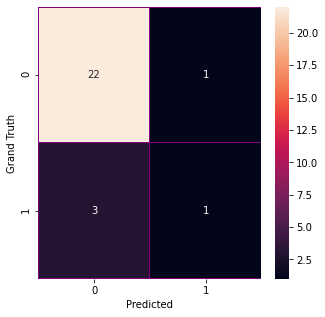

,Precision,Recall,F1 Score
Results,0.5,0.25,0.333333


In [95]:
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [96]:
#Lets try Feature Engineering a new column (SysP-DiasP),
X["BP"]=X['mean systolic bp (mmhg)'] - X['mean diastolic bp (mmhg)']
data=X.drop(['ethnicity', 'mean diastolic bp (mmhg)', 'mean systolic bp (mmhg)'], axis=1)
data.tail()
#Splitting X,y into Train & Test
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((105, 7), (105,))

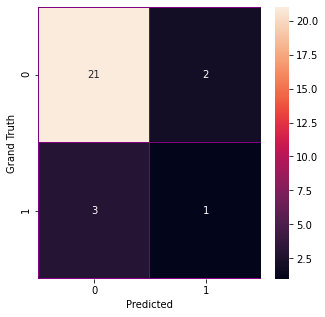

,Precision,Recall,F1 Score
Results,0.333333,0.25,0.285714


In [97]:
score, report, rf, y_pred =randomForest(X_train, X_test, y_train, y_test)
conf_matrix(y_test,y_pred)

In [98]:
score

81.48148148148148

## Create balanced dataset

Oversampling value counts: 1    114
0    114
Name: gestational dm, dtype: int64


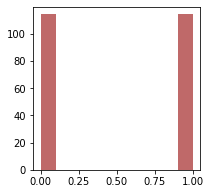

In [122]:
from sklearn.utils import resample

# separate minority and majority classes
majority = dataframe[dataframe['gestational dm']==0]
minority = dataframe[dataframe['gestational dm']==1]

# upsample minority
upsampled = resample(minority,
                          replace=True, # sample with replacement
                          n_samples=len(majority), # match number in majority class
                          random_state=seed) # reproducible results

# combine majority and upsampled minority
upsampled_data = pd.concat([majority, upsampled])


# checking counts after resampling from both the techniques
print(f"Oversampling value counts: {upsampled_data['gestational dm'].value_counts()}")

upsampled_data['gestational dm'].hist(figsize=(3,3), color="brown",alpha=0.7, grid=False);
plt.savefig("balanced_distribution")

In [105]:
#Split oversampled dataset with stratification and drop redundant features
y = upsampled_data['gestational dm']
X = upsampled_data.drop(['gestational dm','ethnicity', 'central armellini fat (mm)', 'mean diastolic bp (mmhg)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
X_train.shape, y_train.shape

((182, 6), (182,))

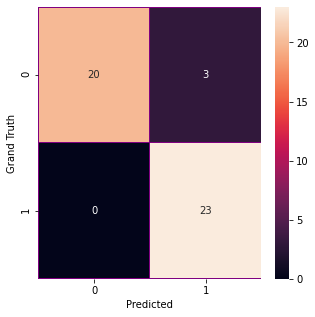

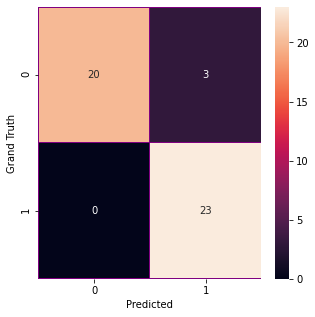

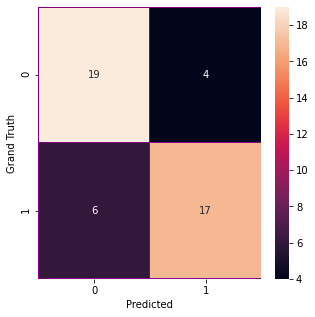

(         Precision  Recall  F1 Score
 Results   0.884615     1.0  0.938776,
          Precision  Recall  F1 Score
 Results   0.884615     1.0  0.938776,
          Precision   Recall  F1 Score
 Results   0.809524  0.73913  0.772727)

In [106]:
# #Balance class weight drop ethnicity:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

rf_model=RandomForestClassifier(random_state=seed).fit(X_train, y_train)
gb_model=RandomForestClassifier(random_state=seed).fit(X_train, y_train)
GradientBoostingClassifier(random_state=seed)
gnb_model=GaussianNB().fit(X_train, y_train)
rf_pred=rf_model.predict(X_test)
gb_pred=gb_model.predict(X_test)
gnb_pred=gnb_model.predict(X_test)
score=accuracy_score(y_test, rf_pred)
conf_matrix(y_test,rf_pred),conf_matrix(y_test,gb_pred),conf_matrix(y_test,gnb_pred)
# X_train.shape

In [38]:
#Test a sample:
Normal=[20, 113, 16.2, 3, 80, 29]
Between=[28, 120, 16.2, 4, 83, 31]
Pos=[33, 137, 18, 5, 86, 35.8]
B=np.array(Pos)
# B
C=B.reshape(1, -1)
rf_model.predict_proba(C), gb_model.predict_proba(C), gnb_model.predict_proba(C)

(array([[0.45, 0.55]]),
 array([[0.45, 0.55]]),
 array([[0.10806874, 0.89193126]]))

In [39]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [44]:
# Get numerical feature importances
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.2541508643770216, 'first fasting glucose (mg/dl)'),
 (0.22744195562344355, 'pregnancies (number)'),
 (0.17139070738135395, 'bmi pregestational (kg/m)'),
 (0.12878442191531328, 'age (years)'),
 (0.12302052340147678, 'current gestational age'),
 (0.09521152730139079, 'mean systolic bp (mmhg)')]

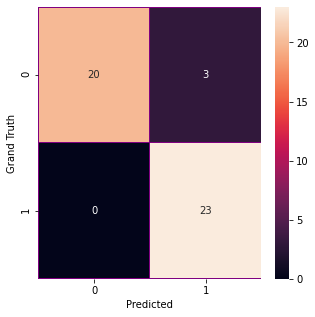

(         Precision  Recall  F1 Score
 Results   0.884615     1.0  0.938776,
 0.9347826086956522)

In [109]:
#Try dropping 'mean systolic bp (mmhg)' as it is least important
X=X.drop(['mean systolic bp (mmhg)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
rf_model_sys=RandomForestClassifier(random_state=seed).fit(X_train, y_train)
rf_pred_sys=rf_model_sys.predict(X_test)
score=accuracy_score(y_test, rf_pred_sys)
conf_matrix(y_test,rf_pred_sys),score

Dropping mean systolic pressure didn't impact the scores, but reduced time

In [51]:
#Hyperparameter tuning:(Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings!)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

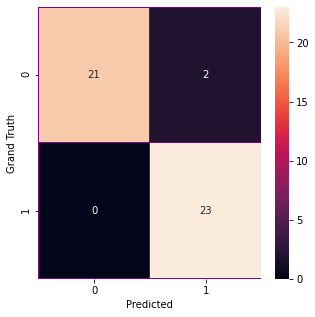

,Precision,Recall,F1 Score
Results,0.92,1.0,0.958333


In [110]:
best_tree = rf_random.best_estimator_.fit(X_train, y_train)
best_pred=best_tree.predict(X_test)
best_score=accuracy_score(y_test, best_pred)
conf_matrix(y_test,best_pred)

In [61]:
print('Improvement of {:0.2f}%.'.format( 100 * (best_score - score) / score))

Improvement of 2.33%.


Reference: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [123]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# First grab positive class prediction probabilities
y_prob = best_tree.predict_proba(X_test)[:,1] 

# Threshold for probabilities that give class predictions.
y_pred = np.where(y_prob > 0.5, 1, 0) 
best_tree.score(X_test, y_pred)
confusion_matrix=metrics.confusion_matrix(y_test,y_pred)
auc_roc=metrics.classification_report(y_test,y_pred)
auc_roc
auc_roc=metrics.roc_auc_score(y_test,y_pred)
auc_roc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.998109640831758

<ipython-input-130-dcad6a1fa491>:7: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  plt.axis('tight', fontsize=19)


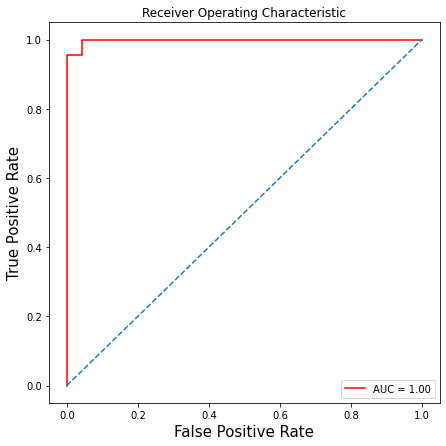

In [130]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight', fontsize=19)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.savefig("AUC.png")

In [119]:
#Save the model to disk and load model and use
import pickle
pickle.dump(best_tree,open('../models/model_tree.pkl','wb') )

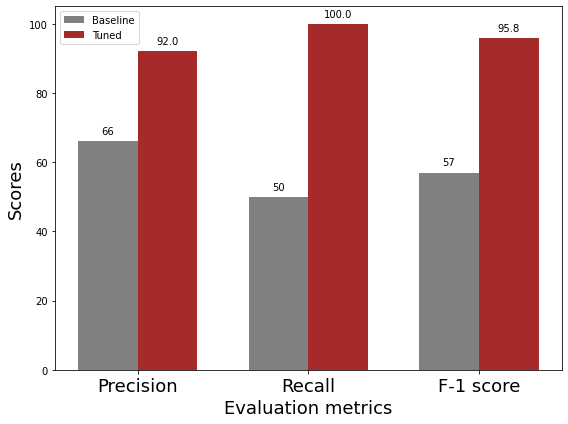

In [38]:
#Compare difference between final and baseline model
labels = ["Precision", "Recall", "F-1 score"]  
Tuned_model = [92, 100, 95.8]
Baseline = [66, 50, 57]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, Baseline, width, label='Baseline', color = 'grey')
rects2 = ax.bar(x + width/2, Tuned_model, width, label='Tuned', color = 'brown')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=18)
ax.set_xlabel('Evaluation metrics', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=18 )
ax.legend(loc= "upper left",fontsize=10)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig("../reports/figures/evaluation_comparison.png")

plt.show()